In [1]:
from __future__ import print_function, division
import os
import torch

from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import sys
sys.path.append("../src")
from split_conf import LCZs

%reload_ext autoreload
%autoreload 2

# dataloader of this dataset

In [6]:
from LCZdataset_loader import LCZdataset, RandomCrop, ToTensor

# show some images from the dataloder

In [7]:
from skimage import exposure

def linearStretch(input, percent):
    pLow, pHigh = np.percentile(input[~np.isnan(input)], (percent, 100 - percent))
    img_rescale = exposure.rescale_intensity(input, in_range=(pLow, pHigh))
    return img_rescale

def show_patch(image):
    """Show image with landmarks"""
    #print(image[:,:,[3,2,1]].shape, image.dtype)
    #print(image[:,:,1], image[:,:,2], image[:,:,3])
    
    img_rescaled = linearStretch(image[:,:,[2,1,0]], 1.25)

    plt.imshow(img_rescaled)
    plt.show()
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 (69, 70, 10) (1,) [14]


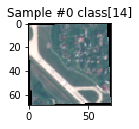

1 (70, 70, 10) (1,) [14]


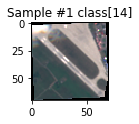

2 (69, 69, 10) (1,) [14]


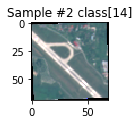

In [8]:
face_dataset = LCZdataset(csv_file='../src/traincities.csv')

fig = plt.figure()

for i in range(len(face_dataset)):
    images, labels = face_dataset[i]

    print(i, images.shape, labels.shape, labels)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{0} class{1}'.format(i,labels))
    #ax.axis('off')
    show_patch(images)

    if i == 2:
        plt.show()
        break

In [9]:
transformed_dataset = LCZdataset(csv_file='../src/traincities.csv',
                                           transform=transforms.Compose([
                                               #Rescale(256),
                                               RandomCrop(64),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    images, labels = transformed_dataset[i]

    print(i, images.size(), labels.size())

    if i == 3:
        break

0 torch.Size([10, 64, 64]) torch.Size([1])
1 torch.Size([10, 64, 64]) torch.Size([1])
2 torch.Size([10, 64, 64]) torch.Size([1])
3 torch.Size([10, 64, 64]) torch.Size([1])


(68, 266, 10)


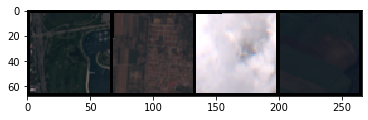

Scattered trees Lightweight low-rise Dense trees Bare soil or sand


In [10]:
import torch
import torchvision

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

def imshow(img):
    npimg = img.numpy()
    
    npimg_ = np.transpose(npimg, (1, 2, 0))
    print(npimg_.shape)
    
    img_rescaled = linearStretch(npimg_[:,:,[2,1,0]], 1.25)
    
    plt.imshow(img_rescaled)
    plt.show()


# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % LCZs[labels[j]] for j in range(4)))

# Define a Convolutional Neural Network

In [11]:
from model import Net

net = Net()
#print(net)

In [12]:
from torchviz import make_dot

images, labels = dataiter.next()
yhat = net(images)
make_dot(yhat, params=dict(list(net.named_parameters()))).render("rnn_torchviz", format="png")



'rnn_torchviz.png'

In [13]:
import hiddenlayer as hl

transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.

graph = hl.build_graph(net, images, transforms=transforms)
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('rnn_hiddenlayer', format='png')

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

NameError: name 'nn' is not defined

# visualizing network and dataset in tensorboard

In [40]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

TypeError: Cannot handle this data type: (1, 1, 10), |u1

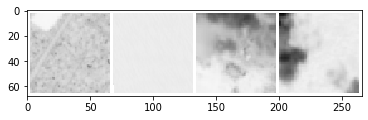

In [45]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

#get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)

# write to tensorboard
writer.add_image('oneBatch', img_grid)

In [46]:
writer.add_graph(net, images)
writer.close()

In [50]:
tensorboard --logdir='./runs/fashion_mnist_experiment_1/' --port =6006

SyntaxError: can't assign to operator (<ipython-input-50-90ec9cac43ef>, line 1)

# training

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        labels = torch.squeeze(labels)
        
        #print(labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.104
[1,   200] loss: 0.099
[1,   300] loss: 0.104
[1,   400] loss: 0.103
[1,   500] loss: 0.101
[1,   600] loss: 0.103
[1,   700] loss: 0.098
[1,   800] loss: 0.096
[1,   900] loss: 0.100
[1,  1000] loss: 0.101
[1,  1100] loss: 0.101
[1,  1200] loss: 0.098
[1,  1300] loss: 0.101
[1,  1400] loss: 0.097
[2,   100] loss: 0.100
[2,   200] loss: 0.094
[2,   300] loss: 0.092
[2,   400] loss: 0.093
[2,   500] loss: 0.093
[2,   600] loss: 0.097
[2,   700] loss: 0.096
[2,   800] loss: 0.092
[2,   900] loss: 0.097
[2,  1000] loss: 0.097
[2,  1100] loss: 0.093


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#  Test the network on the test data

(68, 266, 10)


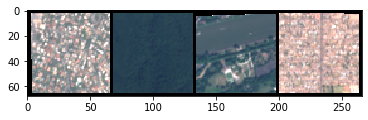

GroundTruth:  Open low-rise Dense trees Scattered trees Open low-rise


In [17]:
transformed_dataset_tst = LCZdataset(csv_file='../src/testcities.csv',
                                           transform=transforms.Compose([
                                               RandomCrop(64),
                                               ToTensor()
                                           ]))

testloader = DataLoader(transformed_dataset_tst, batch_size=4,
                        shuffle=True, num_workers=0)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % LCZs[labels[j]] for j in range(4)))



In [18]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % LCZs[predicted[j]]
                              for j in range(4)))

Predicted:  Large low-rise Dense trees Water Large low-rise


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))